# The ultimate otaku recommender system

In [28]:
!pip install surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.0/772.0 kB 8.0 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp310-cp310-macosx_12_0_x86_64.whl size=1187832 sha256=1e3490b25b92f1fa50257431741c894b8ce5c4a23f43fb1b00698cb86559b099
  Stored in directory: /Users/fsiri/Library/Caches/pip/wheels/a5/ca/a8/4e28def53797fdc4363ca4af740db15a9c2f1595ebc51fb445
Successfully built scikit-surprise


In [29]:
from collections import defaultdict
import pandas as pd
import numpy as np
import scipy
from scipy.sparse.linalg import svds
import matplotlib.pyplot as plt
import surprise as sp
import time

This notebook presents a beginner friendly solution for a [Recommender System](https://en.wikipedia.org/wiki/Recommender_system) problem at the MyAnimeList portal. The main idea here is to understand the data presented to us, do all the cleaning and exploration stuff and then test and apply different algorithms so we have available either a User-based and an Item-based Collaborative Filtering system.

# Context and motivation

If any of you have already searched for info and rating about a Anime on the internet, you probably were sent to the [MyAnimeList](www.myanimelist.net) website. It is like the IMDB of japanese content, and has a lot of different ways for you to find something suitable to you as "Top Airing", "Top Upcoming" and so on. The score of a certain anime is actually the global mean of all the ratings given by the users (I'm not quite sure about this info, but I imagine this is the case). Rates go from 0 to 10, and whenever you create your account you can score pretty much anything you want.

Ever since I've learned how [Spotify created and developed their awesome recommendation system](https://medium.com/s/story/spotifys-discover-weekly-how-machine-learning-finds-your-new-music-19a41ab76efe) I got more and more interested about how all of this stuff works in practice and started to be more curious about it. 

Now, how I connected these two stories. A while ago, I was looking for something to watch and thought "Hey, maybe I can go to MyAnimeList, give my scores of previous watched animes and maybe find something good recommended to me, kind of like Netflix and Spotify do". But since you are reading up until here, you can imagine that this is not a feature they had available in their website, which coincidentally happenned in the same time I had to think of my final project for the [Machine Learning Engineer course](https://www.udacity.com/course/machine-learning-engineer-nanodegree--nd009t) from Udacity (that I highly recommend if you have the money to spend). So hey, why not do it?

# Datasets

For the dataset, we will use the [awesome data](https://www.kaggle.com/azathoth42/myanimelist/version/9#_=_) from azazoth42 (huge thanks!). To make the cleaning data process easy, we will use only the CSVs that do not contain any null values (which have the cleaned suffix on them). 

The datasets are mainly divided in three. One with info about the MyAnimeList customers (UsersDF) such as location, gender, birth date and so on. Another one for info about the anime, which brings data like the title of the show, what genre is it inside and even the opening themes. The last one (and also the biggest one) is all the scores that a certain user had with a show (that have 31M rows of interactions, wow).

In [43]:
#Importing the CSVs to Dataframe format
UsersDF = pd.read_csv('users_cleaned.csv')
#AnimesDF = pd.read_csv('anime_cleaned.csv')
#ScoresDF = pd.read_csv('animelists_cleaned.csv')

#AnimesDF.head()

In [5]:
UsersDF.head()

,username,user_id,user_watching,user_completed,user_onhold,user_dropped,user_plantowatch,user_days_spent_watching,gender,location,birth_date,access_rank,join_date,last_online,stats_mean_score,stats_rewatched,stats_episodes
0,karthiga,2255153,3,49,1,0,0,55.091667,Female,"Chennai, India",1990-04-29 00:00:00,NaN,2013-03-03 00:00:00,2014-02-04 01:32:00,7.43,0.0,3391
1,Damonashu,37326,45,195,27,25,59,82.574306,Male,"Detroit,Michigan",1991-08-01 00:00:00,NaN,2008-02-13 00:00:00,2017-07-10 06:52:54,6.15,6.0,4903
2,bskai,228342,25,414,2,5,11,159.483333,Male,"Nayarit, Mexico",1990-12-14 00:00:00,NaN,2009-08-31 00:00:00,2014-05-12 16:35:00,8.27,1.0,9701
3,terune_uzumaki,327311,5,5,0,0,0,11.394444,Female,"Malaysia, Kuantan",1998-08-24 00:00:00,NaN,2010-05-10 00:00:00,2012-10-18 19:06:00,9.70,6.0,697
4,Bas_G,5015094,35,114,6,20,175,30.458333,Male,"Nijmegen, Nederland",1999-10-24 00:00:00,NaN,2015-11-26 00:00:00,2018-05-10 20:53:37,7.86,0.0,1847


In [6]:
ScoresDF.head()

,username,anime_id,my_watched_episodes,my_start_date,my_finish_date,my_score,my_status,my_rewatching,my_rewatching_ep,my_last_updated,my_tags
0,karthiga,21,586,0000-00-00,0000-00-00,9,1,NaN,0,2013-03-03 10:52:53,NaN
1,karthiga,59,26,0000-00-00,0000-00-00,7,2,NaN,0,2013-03-10 13:54:51,NaN
2,karthiga,74,26,0000-00-00,0000-00-00,7,2,NaN,0,2013-04-27 16:43:35,NaN
3,karthiga,120,26,0000-00-00,0000-00-00,7,2,NaN,0,2013-03-03 10:53:57,NaN
4,karthiga,178,26,0000-00-00,0000-00-00,7,2,0.0,0,2013-03-27 15:59:13,NaN


In [7]:
#Since ScoresDF is a huge DF (2GB of data) I`ll only take the columns that are important for the recommendation system
ScoresDF = ScoresDF[['username', 'anime_id', 'my_score', 'my_status']]

In [8]:
ScoresDF['my_score'].describe().apply(lambda x: format(x, '.2f')).reset_index()

,index,my_score
0,count,31284030.00
1,mean,4.65
2,std,3.93
3,min,0.00
4,25%,0.00
5,50%,6.00
6,75%,8.00
7,max,10.00


In [9]:
#Analysing all the possible values for the score, this will be used as a parameter later on
lower_rating = ScoresDF['my_score'].min()
upper_rating = ScoresDF['my_score'].max()
print('Range of ratings vary between: {0} to {1}'.format(lower_rating, upper_rating))

Range of ratings vary between: 0 to 10


Before moving on to later analyses, there is something worth mentioning. The column 'my_status' that we maintaned in the Scores Dataframe represents the following data about the relation of the customer about the show:

1: watching
2: completed
3: on hold
4: dropped
6: plan to watch

One optiong would be just considering interactions coming from completed animes, but I came to the conclusion that the info about the other status are relevant too and shouldn't be recommended for the specific customer again, so they were kept in to the dataframe (even though I have an example of treating this data in the next annotations).

In [10]:
#Only filtering animes in which people actually watched, are watching or are on hold as they are the most revelant for the rec sys
#RelevantScoresDF = ScoresDF[(ScoresDF['my_status'] == 1) | (ScoresDF['my_status'] == 2) | (ScoresDF['my_status'] == 3)]

In [11]:
#Counting how many relevant scores each user have done, resetting the index (so the series could become a DF again) and changing the column names
UsersAndScores = ScoresDF['username'].value_counts().reset_index().rename(columns={"username": "animes_rated", "index": "username"})

In [12]:
UsersSampled = UsersDF.sample(frac = .01, random_state = 2)
UsersSampled.head()

,username,user_id,user_watching,user_completed,user_onhold,user_dropped,user_plantowatch,user_days_spent_watching,gender,location,birth_date,access_rank,join_date,last_online,stats_mean_score,stats_rewatched,stats_episodes
48731,Saperella,98375,21,162,0,4,28,34.550000,Male,"York, UK",1989-08-31 00:00:00,NaN,2008-09-25 00:00:00,2010-07-22 05:41:00,7.94,4.0,2131
35191,Inugirlz,207889,52,908,227,164,300,301.467361,Female,Where Maple Leaves Reside,1994-04-04 00:00:00,NaN,2009-07-14 00:00:00,2018-05-19 14:23:41,7.16,58.0,18796
77699,Luu-Senpai,5393511,10,663,0,0,19,177.401111,Male,Buenos Aires,1991-05-23 00:00:00,NaN,2016-05-07 00:00:00,2018-04-27 04:38:21,7.72,0.0,11129
95207,OzzyOtaku,607875,16,342,0,76,69,91.565278,Male,TEXAS,1989-01-24 00:00:00,NaN,2011-09-19 00:00:00,2018-05-20 18:51:57,7.77,18.0,5987
85049,Ahlala,485718,1,67,29,8,32,37.024306,Female,Philippines,1991-04-10 00:00:00,NaN,2011-05-12 00:00:00,2017-07-27 01:10:00,8.31,27.0,2251


Since the DF will be too big to run some of the later algorithms, I sampled 1% of the users. The reason behind doing this right now in this specific DF is to sample people without losing info about their ratings. If I sampled them in the ScoresDF, an example that I tried to avoid is sampling a customer that had 100 interactions with just 1 interaction now, and that would hurt the accuracy of the model later on.

In [13]:
UsersAndScoresSampled = pd.merge(UsersAndScores, UsersSampled, left_on = 'username', right_on = 'username', how = 'inner')

The reason I sampled the UsersDF and then joined with the UsersAndScores and not just simply sampled the UsersAndScores directly is that I don't know why I can't reproduce the same sampled DF everytime (with the random_seed). If any of you know why, please give me some feedback!

In [14]:
#Grouping users whom had the same amount of animes rated
UserRatedsAggregated = UsersAndScoresSampled['animes_rated'].value_counts().reset_index().rename(columns={"animes_rated": "group_size", "index": "animes_rated"}).sort_values(by=['animes_rated'])

In [15]:
#Counting how many relevant scores each anime has, resetting the index (so the series could become a DF again) and changing the column names
RatedsPerAnime = ScoresDF['anime_id'].value_counts().reset_index().rename(columns={"anime_id": "number_of_users", "index": "anime_id"})
RatedsPerAnime.head()

,anime_id,number_of_users
0,1535,81332
1,1575,67721
2,226,64486
3,5114,63649
4,4224,63278


In [16]:
#Grouping users whom had the same amount of animes rated
AnimeRatedsAggregated = RatedsPerAnime['number_of_users'].value_counts().reset_index().rename(columns={"number_of_users": "group_size", "index": "number_of_users"}).sort_values(by=['number_of_users'])
AnimeRatedsAggregated.head(n = 30)

,number_of_users,group_size
331,1,3
27,2,11
25,3,11
23,4,12
6,5,16
18,6,13
14,7,14
7,8,16
0,9,22
2,10,21


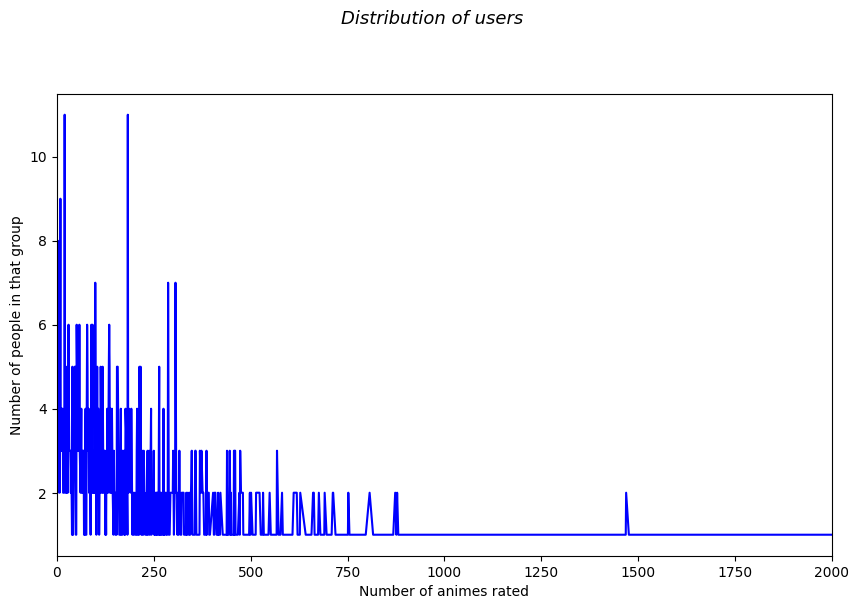

In [24]:
#Creating the plots so we can gather information about the distribution of ratings in the sample
plt.figure(figsize=(10, 6))
plt.suptitle("Distribution of users", fontsize=13, fontweight=0, color='black', style='italic', y=1.02)
plt.plot('animes_rated', 'group_size', data = UserRatedsAggregated, color = 'blue')
plt.xlabel('Number of animes rated')
plt.ylabel('Number of people in that group')
plt.xlim(left = 0, right = 2000)
plt.show()

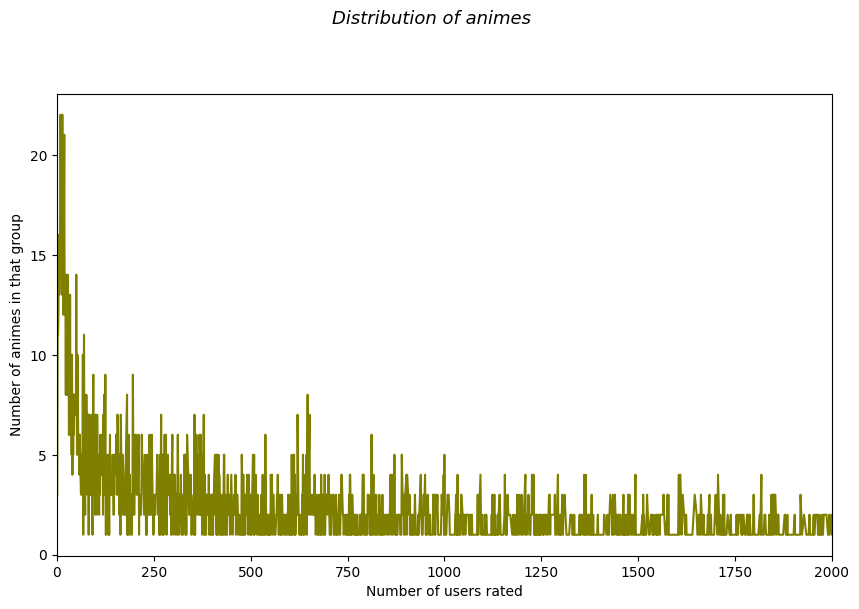

In [23]:
#Creating the plots so we can gather information about the distribution of ratings in the sample
plt.figure(figsize=(10, 6))
plt.suptitle("Distribution of animes", fontsize=13, fontweight=0, color='black', style='italic', y=1.02)
plt.plot('number_of_users', 'group_size', data = AnimeRatedsAggregated, color = 'olive')
plt.xlabel('Number of users rated')
plt.ylabel('Number of animes in that group')
plt.xlim(left = 0, right = 2000)
plt.show()

Here we create another dataframe which contains only users and animes that have at least 10 interactions. We then combine this data by merging our initial frame with the RatedsPerUser and the RatedsPerAnime. 

The reason for this is trying to solve a problem that Recommender Systems commonly runs in to, that is the 'Cold Start Problem'. It is really hard to recommend something to a customer that you do not have data about, but there are several ways to deal with it, such as a Popularity Recommender (where I'll recommend to my new users the most liked products) and other stuff, but I'll just exclude them from my analysis since I already have a lot of data.

In [19]:
#Creating a dataframe of users  and animes with more than 10 interactions
UserRatedsCutten = UsersAndScoresSampled[UsersAndScoresSampled['animes_rated'] >= 10]
AnimeRatedsCutten = RatedsPerAnime[RatedsPerAnime['number_of_users'] >= 10]
#Joining (merging) our new dataframes with the interactions one (this will already deal with the sample problem,
#as it is an inner join). The "HotStart" name comes from a pun about solving the "Cold Start" issue
ScoresDFHotStart = pd.merge(ScoresDF, UserRatedsCutten, left_on = 'username', right_on = 'username', how = 'inner')
ScoresDFHotStart = pd.merge(ScoresDFHotStart, AnimeRatedsCutten, left_on = 'anime_id', right_on = 'anime_id', how = 'inner')

Another info that would be interesting to know is how are the user scores distributed. That could explain us what number represents something that the user liked or not (and will be used later on as a treshold too).

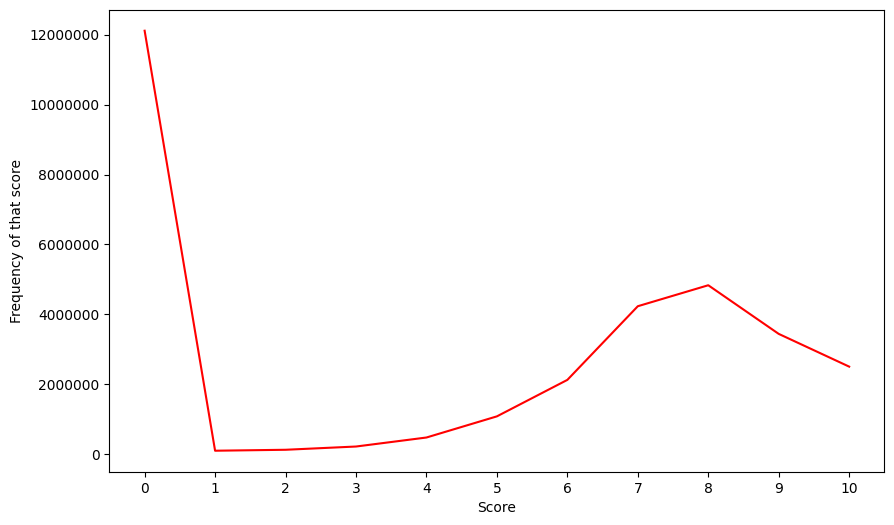

In [25]:
#Grouping the different scores and resetting the index (so the series could become a DF again) 
AnimeRates = ScoresDF['my_score'].value_counts().reset_index().sort_values('index')
plt.figure(figsize=(10, 6))
plt.plot('index', 'my_score', data = AnimeRates, color = 'red')
plt.xticks(np.arange(11))
plt.ticklabel_format(axis = 'y', style = 'plain')
plt.xlabel('Score')
plt.ylabel('Frequency of that score')
plt.show()

Here we can imply being that the data has a peak at the score of number '7', probably when someone really likes a show it rates them at that minimum. Interesting to see too that we have a lot of rated '0', Otakus are really demanding apparently.

In [21]:
#Just for the record, lets see the difference in numbers between our initial DF and the sampled and cleaned one

print('The initial dataframe has {0} registers and the sampled one has {1} rows.'.format(ScoresDF['username'].count(), ScoresDFHotStart['username'].count()))

The initial dataframe has 31283787 registers and the sampled one has 324206 rows.


# Metrics

In the following links there are explanations about how the most important metrics work:

[RMSE and MAE](https://medium.com/human-in-a-machine-world/mae-and-rmse-which-metric-is-better-e60ac3bde13d)

[Precision@k and Recall@k](https://medium.com/@m_n_malaeb/recall-and-precision-at-k-for-recommender-systems-618483226c54)

For this specific model, I chose to base my choice on the Precision@k metric (specifically the Precision@10). The advantage of this metric above all else is the importance that it gives to the items that you actually want to recommend. The problem I see for RMSE and MAE right here is that they do their calculation for all items in the model and I'm not interested, let's say, in the difference of the true rating and the estimated rating for the 376th (sorted by descending rating) item of my customer. And the problem with the Recall@k is that I won't be able to recommend all the relevant items since some of my users have 1000 animes scored.


In [30]:
def precision_recall_at_k(predictions, k=10, threshold= 7):
    '''Return precision and recall at k metrics for each user.'''

    # First map the predictions to each user.
    # Predictions: Traz uma lista de 5 campos dentro de uma tupla com as seguintes infos: User_ID, Item_ID, True_ID, Est_ID, Details
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))
    # Creates a dict with the key being a user and the value bringing the estimated rating and the true rating.

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 1

        # Recall@K: Proportion of relevant items that are recommended
        recalls[uid] = n_rel_and_rec_k /  n_rel if n_rel != 0 else 1

    return precisions, recalls

# Training, testing and results structure

My initial idea was to create a user-based algorithm, where you could input a specific username and it would return to you the top@K recommendations, but I also thought of developing an item-based system, as it would be a lot better to have an empiral understanding if all of it is working or not.

So, how can I know if my algorithm is performing well or not? For this problem we split the data in a **Training** and a **Test** dataset (with a 75/25 proportion). The idea behind it is to try to guess the score for animes where we actually can do a comparison. For instance, lets say you gave an score of 10, 9, 8 and 3 to the following shows: Dragon Ball Z, Pokemon, Naruto and One Piece. We then split the first three animes, learn by it and try to estimate what would be your One Piece score, and the difference of the estimated score and the true score would tell us the performance of the recommender.

After spliting the data, I've constructed a function where we can compare pretty much any algo from the awesome [Surprise](http://surpriselib.com/) lib (the only one I left out was the SVD++ for performance reasons), and then, comparing all the metrics (which I'll explain in the next cell) I chose the best recommender for this specific case.

In [31]:
random_state = 42
reader = sp.Reader(rating_scale=(0, 10))
data = sp.Dataset.load_from_df(ScoresDFHotStart[['username', 'anime_id', 'my_score']], reader)
trainset, testset = sp.model_selection.train_test_split(data, test_size=.25, random_state = random_state)
analysis = defaultdict(list)

test_dict = {'SVD' : sp.SVD(random_state=random_state), 'SlopeOne' : sp.SlopeOne(), 'NMF' : sp.NMF(random_state=random_state), 'NormalPredictor' : sp.NormalPredictor(), 'KNNBaseline' : sp.KNNBaseline(random_state=random_state), 'KNNBasic' : sp.KNNBasic(random_state=random_state), 'KNNWithMeans' : sp.KNNWithMeans(random_state=random_state), 'KNNWithZScore' : sp.KNNWithZScore(random_state=random_state), 'BaselineOnly' : sp.BaselineOnly(), 'CoClustering': sp.CoClustering(random_state=random_state)}

for key, value in test_dict.items():
    start = time.time()    
    value.fit(trainset)
    predictions = value.test(testset)

    rmse = sp.accuracy.rmse(predictions)
    precisions, recalls = precision_recall_at_k(predictions, k=10, threshold=7)
    precision_avg = sum(prec for prec in precisions.values()) / len(precisions)

    analysis[value] = (key, rmse, precision_avg, time.time() - start)

print(analysis)

RMSE: 3.5223
RMSE: 3.2537
RMSE: 3.3655
RMSE: 5.1276
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 3.2144
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 3.3635
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 3.2437
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 3.2470
Estimating biases using als...
RMSE: 3.2434
RMSE: 3.2912
defaultdict(<class 'list'>, {<surprise.prediction_algorithms.matrix_factorization.SVD object at 0x289ca4eb0>: ('SVD', 3.5222804706178525, 0.7650220755610538, 16.60153818130493), <surprise.prediction_algorithms.slope_one.SlopeOne object at 0x289ca4e20>: ('SlopeOne', 3.2536559182968485, 0.8957212368425065, 34.74051380157471), <surprise.prediction_algorithms.matrix_factorization.NMF object at 0x289ca48e0>: ('NMF', 3.3655207163253396, 0.7961386864659232, 5.831878900527954), <surprise.prediction_algorithms.random_pr

In [32]:
analysis_df = pd.DataFrame.from_dict(analysis, orient = 'index', columns = ['Algorithm', 'RMSE', 'Precision@10', 'Time to run (in seconds)']).reset_index()

#analysis_df['Algorithm'] = ['SVD', 'SlopeOne', 'NMF', 'NormalPredictor', 'KNNBaseline', 'KNNBasic', 'KNNWithMeans', 'KNNWithZScore', 'BaselineOnly', 'CoClustering']
analysis_df = analysis_df[['Algorithm', 'RMSE', 'Precision@10', 'Time to run (in seconds)']]
analysis_df = analysis_df.sort_values(by=['Precision@10'], ascending = False)
analysis_df['RMSE^-1'] = analysis_df['RMSE'] ** -1
analysis_df.head(n = 15)

,Algorithm,RMSE,Precision@10,Time to run (in seconds),RMSE^-1
8,BaselineOnly,3.243375,0.916755,1.202928,0.308321
1,SlopeOne,3.253656,0.895721,34.740514,0.307347
6,KNNWithMeans,3.243719,0.893348,10.728014,0.308288
4,KNNBaseline,3.214395,0.883658,12.166034,0.311101
9,CoClustering,3.291171,0.865126,5.656095,0.303843
7,KNNWithZScore,3.247020,0.845872,11.230363,0.307975
5,KNNBasic,3.363484,0.825126,11.146553,0.297311
2,NMF,3.365521,0.796139,5.831879,0.297131
0,SVD,3.522280,0.765022,16.601538,0.283907
3,NormalPredictor,5.127552,0.538041,0.868023,0.195025


Now I cleaned all the results data and inverted the RMSE (just because having a greater RMSEˆ-1 is now good and it looks better in a chart) and wil scatter plot them to see their difference in performance, but we can see right now that the best performing algorithm was the BaselineOnly.

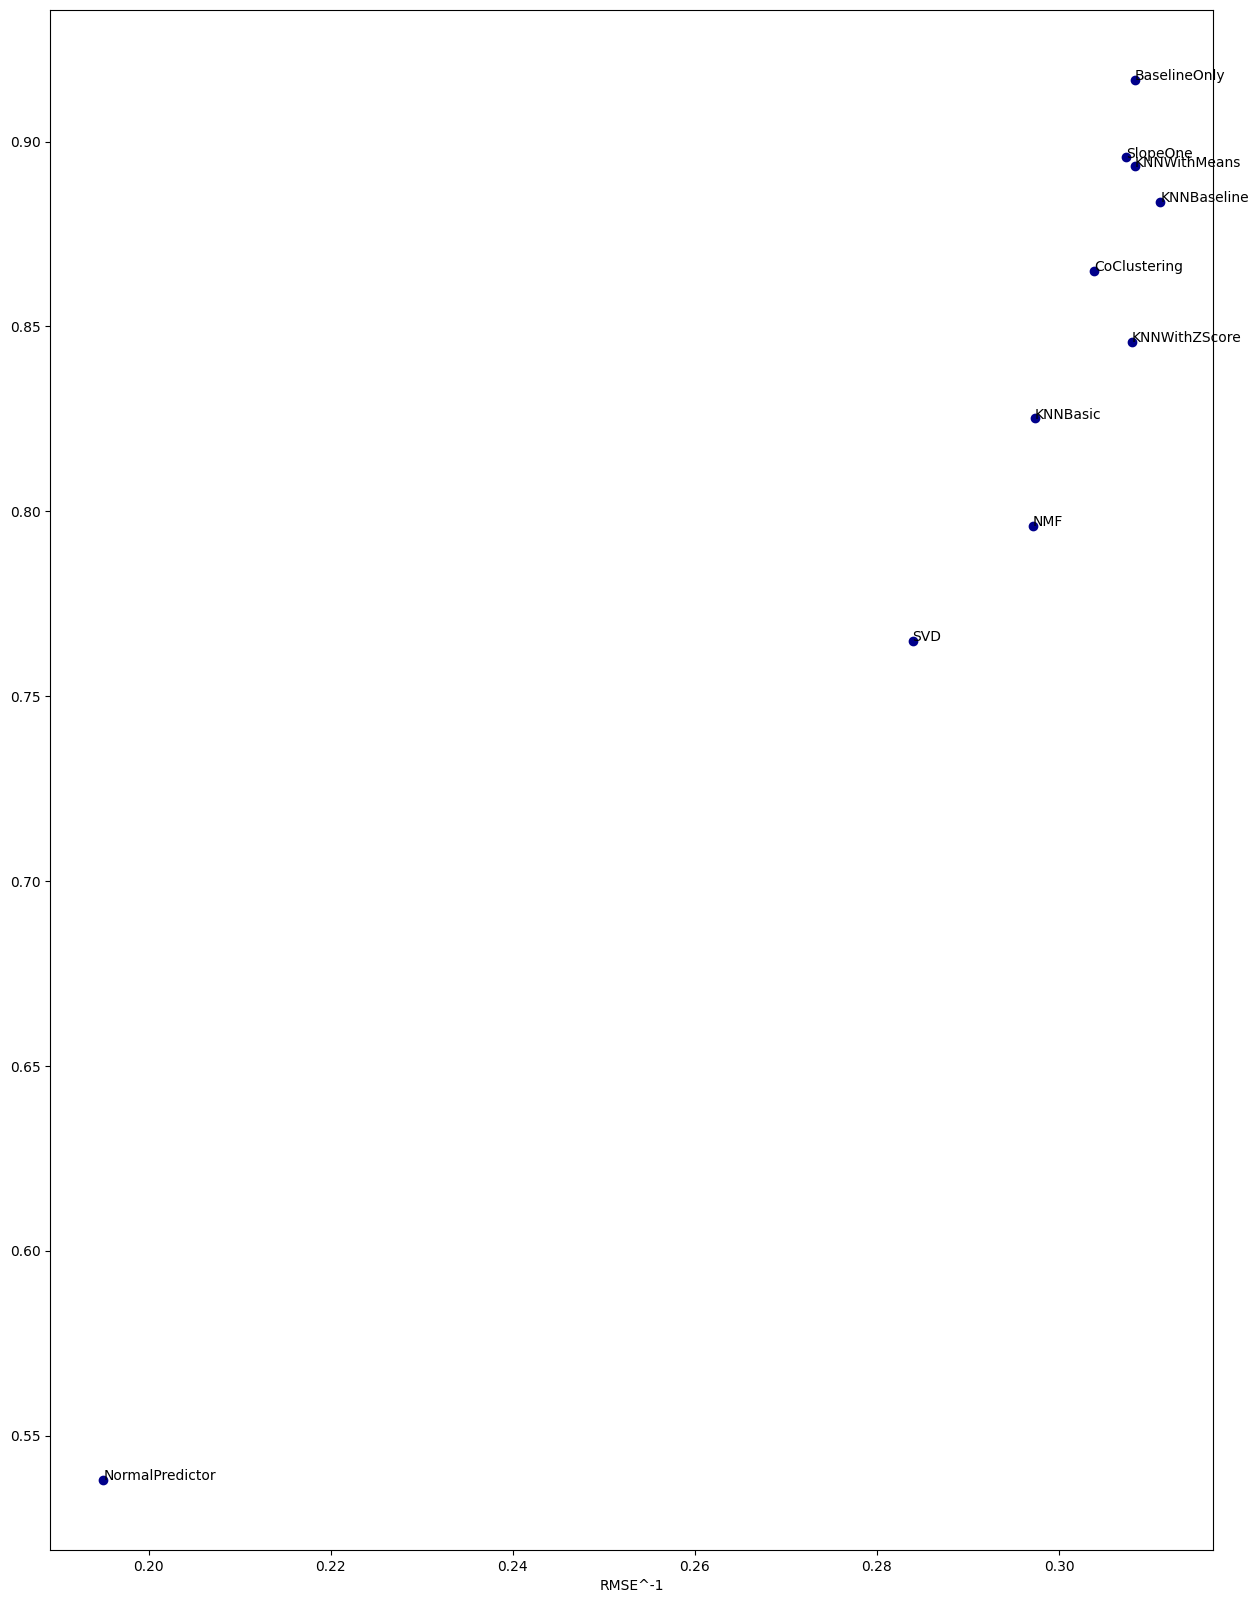

In [33]:
ax = analysis_df.set_index('RMSE^-1')['Precision@10'].plot(style='o', c = 'DarkBlue', figsize = (15, 20))
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    
def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x'], point['y'], str(point['val']))

label_point(analysis_df['RMSE^-1'], analysis_df['Precision@10'], analysis_df['Algorithm'], ax)

Funny enough, the BaselineOnly is one of the simplest and least costing collaborative filtering algorithms. There is a definition on its paper that explains it better than I can:

" For example, suppose that we want a baseline
estimate for the rating of the movie Titanic by user Joe. Now, say that the
average rating over all movies, μ, is 3.7 stars. Furthermore, Titanic is better
than an average movie, so it tends to be rated 0.5 stars above the average. On
the other hand, Joe is a critical user, who tends to rate 0.3 stars lower than the
average. Thus, the baseline estimate for Titanic’s rating by Joe would be 3.9
stars by calculating 3.7 − 0.3 + 0.5. "

That is how Machine Learning works, sometimes a linear regression works better than a neural network.

Now that I chose my best algorithm I need to generate new recommendations for my users. For that reason, I create a  new training set, now containing all available scores and create a testing set with all animes the user didn't score but are on the training set for other users (that's why we need to take care on the site of the sample, since this part can be very costly).

In [34]:
als_param_grid = {'bsl_options': {'method': ['als'],
                              'reg_i': [5, 10, 15],
                              'reg_u': [10, 15, 20],
                              'n_epochs': [5, 10, 15, 20]
                              }
              }

sgd_param_grid = {'bsl_options': {'method': ['sgd'],
                              'reg': [0.01, 0.02, 0.03],
                              'n_epochs': [5, 10, 15, 20],
                              'learning_rate' : [0.001, 0.005, 0.01]
                              }
              }

als_gs = sp.model_selection.GridSearchCV(sp.BaselineOnly, als_param_grid, measures=['rmse'], cv = 3, joblib_verbose = 0)

sgd_gs = sp.model_selection.GridSearchCV(sp.BaselineOnly, sgd_param_grid, measures=['rmse'], cv = 3, joblib_verbose = 0)

In [35]:
als_gs.fit(data)

# best RMSE score
print(als_gs.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(als_gs.best_params['rmse'])

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimati

In [36]:
sgd_gs.fit(data)

# best RMSE score
print(sgd_gs.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(sgd_gs.best_params['rmse'])

Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimati

Ironically enough, the default options for the parameters actually brought a better RMSE than the tweak of both grids, so we we won't change anything.

In [37]:
trainset = data.build_full_trainset()
algo = sp.BaselineOnly()
algo.fit(trainset)
testset = trainset.build_anti_testset()
predictions = algo.test(testset)
    
last_predictions = pd.DataFrame(predictions, columns=['uid', 'iid', 'rui', 'est', 'details'])
last_predictions.drop('rui', inplace = True, axis = 1)

Estimating biases using als...


After generating the list with all possible recommendations, I created another function that shows only the k most valuable recommendations for each customer. That way we can simulate how an actually recommender system works.

In [38]:
def bringing_first_n_values(df, uid, n=10):
    df = df[df['uid'] == uid].nlargest(n, 'est')[['uid', 'iid', 'est']]
    df = pd.merge(df, AnimesDF, left_on = 'iid', right_on = 'anime_id', how = 'left')
    return df[['uid', 'est', 'title', 'genre']]

In [39]:
bringing_first_n_values(last_predictions, 'Tomoki-sama')

,uid,est,title,genre
0,Tomoki-sama,8.050706,Howl no Ugoku Shiro,"Adventure, Drama, Fantasy, Romance"
1,Tomoki-sama,7.910537,Mononoke Hime,"Action, Adventure, Fantasy"
2,Tomoki-sama,7.845694,Clannad: After Story,"Slice of Life, Comedy, Supernatural, Drama, Ro..."
3,Tomoki-sama,7.778978,Dragon Ball Z,"Action, Adventure, Comedy, Fantasy, Martial Ar..."
4,Tomoki-sama,7.743585,Kimi no Na wa.,"Supernatural, Drama, Romance, School"
5,Tomoki-sama,7.696071,Shelter,"Sci-Fi, Music"
6,Tomoki-sama,7.593356,Final Fantasy VII: Advent Children,"Action, Super Power, Fantasy"
7,Tomoki-sama,7.593259,"Clannad: Mou Hitotsu no Sekai, Tomoyo-hen","Drama, Romance, School, Slice of Life"
8,Tomoki-sama,7.545917,One Piece 3D2Y: Ace no shi wo Koete! Luffy Nak...,"Adventure, Comedy, Fantasy, Shounen"
9,Tomoki-sama,7.541329,Tenkuu no Shiro Laputa,"Adventure, Fantasy, Romance, Sci-Fi"


Now, as I mentioned early on, I've built an item-based recommender just so we can test if our recommendations make any sense. Not all algorithms can do the item-item recommendation, so the most used ones are the unsupervised-learning-based (as this KNN that I actually use). 

In [40]:
sim_options = {'name': 'pearson_baseline', 'user_based': False}
algo_items = sp.KNNBaseline(sim_options=sim_options)
algo_items.fit(trainset)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [41]:
def get_item_recommendations(anime_title, anime_id=100000, k=10):
    if anime_id == 100000:     
        anime_id = AnimesDF[AnimesDF['title'] == anime_title]['anime_id'].iloc[0]
        
    iid = algo_items.trainset.to_inner_iid(anime_id)
    neighbors = algo_items.get_neighbors(iid, k=k)
    raw_neighbors = (algo.trainset.to_raw_iid(inner_id) for inner_id in neighbors)
    df = pd.DataFrame(raw_neighbors, columns = ['Anime_ID'])
    df = pd.merge(df, AnimesDF, left_on = 'Anime_ID', right_on = 'anime_id', how = 'left')
    return df[['Anime_ID', 'title', 'genre']]

As I already trained the model and created a function that brings a show based on it's name (if you want to know the exactly name copy how it is written in www.myanimelist.net) let's test it with one of the most famous animes of all time. Dragon Ball! 

In [42]:
get_item_recommendations('Naruto', k=30)

,Anime_ID,title,genre
0,1735,Naruto: Shippuuden,"Action, Adventure, Comedy, Super Power, Martia..."
1,594,Naruto: Takigakure no Shitou - Ore ga Eiyuu Da...,"Action, Adventure, Comedy, Shounen, Super Power"
2,269,Bleach,"Action, Adventure, Comedy, Super Power, Supern..."
3,761,Naruto: Akaki Yotsuba no Clover wo Sagase,"Adventure, Comedy, Shounen"
4,16498,Shingeki no Kyojin,"Action, Military, Mystery, Super Power, Drama,..."
5,1074,Naruto Narutimate Hero 3: Tsuini Gekitotsu! Jo...,"Adventure, Comedy, Game, Shounen"
6,552,Digimon Adventure,"Action, Adventure, Comedy, Fantasy, Kids"
7,223,Dragon Ball,"Adventure, Comedy, Fantasy, Martial Arts, Shou..."
8,10686,Naruto: Honoo no Chuunin Shiken! Naruto vs. Ko...,"Action, Adventure, Martial Arts, Shounen, Supe..."
9,1535,Death Note,"Mystery, Police, Psychological, Supernatural, ..."


Cool, the first two ones are Dragon Ball Z and GT! But wait, how on earth is Pokemon similar to Dragon Ball? After questioning it to myself I realized that, as a child, every morning I used to watch Dragon Ball, Pokemon and Yu-Gi-Oh and talk about it with my friends at school... So hey, we already saw a pattern! Maybe if someone likes some anime, they have a higher chance of liking a show that launched in the same decade, at least, than a show with the same genres. That's the magic of collaborative filtering! You don't have to tell the patterns to the model, you have to try to understand them after.

# Conclusion

Thanks for reading this up until here. This is my first Kaggle and I hope you guys enjoyed my didatic! Any feedback is welcome, please feel free to comment here or send me a message, here is my [linkedin profile](https://www.linkedin.com/in/gabriel-martelloti-a3ab87b6/). 

Sources:
[surprise lib documentation](https://surprise.readthedocs.io/en/stable/)

[Collaborative filtering with surprise application](https://towardsdatascience.com/building-and-testing-recommender-systems-with-surprise-step-by-step-d4ba702ef80b)

[This awesome Kaggle which inspired me](https://www.kaggle.com/gspmoreira/recommender-systems-in-python-101)

[The paper for the BaselineOnly method](http://courses.ischool.berkeley.edu/i290-dm/s11/SECURE/a1-koren.pdf)